In [1]:
import datetime
import numpy as np
from collections import defaultdict
from typing import Dict, List, Optional, Tuple, Union

import pandas as pd
#import tables

import pycountry

from pylab import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from bigbang.analysis.listserv import ListservMailList
#from bigbang.bigbang_io import pandas_dataframe_to_mbox

from tgpp.config.config import CONFIG
import tgpp.ingress.queries as Queries
from tgpp.ingress import organizations as ORGA

plt.style.use("./publication_jcap.mplstyle")

## Load data

In [2]:
category_abbr_dict = {
    'Advertising company': 'Advertising company',
    'Chipmaker': 'Chipmaker',
    'Civil Society Organization': 'Civil Society Organization',
    'Cloud Provider': 'Cloud Provider',
    'Consulting': 'Consulting',
    'Consumer hardware and software vendor': 'Consumer hardware and\n software vendor',
    'Content Distribution Network': 'Content Distribution\n Network',
    'Content Provider': 'Content Provider',
    'Cybersecurity': 'Cybersecurity',
    'Database Provider': 'Database Provider',
    'Financial Institution': 'Financial Institution',
    'Hackerspace': 'Hackerspace',
    'Hardware Developer': 'Hardware Developer',
    'Hardware Provider': 'Hardware Provider',
    'IETF secretariat': 'IETF Secretariat',
    'Infrastructure Company': 'Infrastructure Company',
    'Internet Governance Body': 'Internet Governance Body',
    'Internet Registry': 'Internet Registry',
    'Law Enforcement Agency': 'Law Enforcement Agency',
    'Networking equipment vendor': 'Networking Equipment Vendor',
    'Networking Service Provider': 'Networking Service Provider',
    'Real time video': 'Real Time Video',
    'Regional Standards Body': 'Regional Standards Body',
    'Regulatory Body': 'Regulatory Body',
    'Research Institution': 'Research Institution',
    'Satellite Communications Provider': 'Satellite Communications Provider',
    'Software Provider': 'Software Provider',
    'Software Developer': 'Software Developer',
    'Space Agency': 'Space Agency',
    'Standards Body': 'Standards Body',
    'Technology research and development company': 'Technology Research and\n Development Company',
    'Telecommunications Provider': 'Telecommunications Provider',
    'Testing and Certification': 'Testing and Certification',
    'Public Finances and Economic Policy': 'Public Finances and\n Economic Policy',
    'Defence Agency': 'Defence Agency',
}

country_abbr_dict = {
    'Australia': 'AUS',
    'Austria': 'AUT',
    'Belgium': 'BEL',
    'Brazil': 'BRA',
    'Canada': 'CAN',
    'China': 'CHN',
    'Czech Republic': 'CZE',
    'Denmark': 'DNK',
    'Dominica': 'DMA',
    'Finland': 'FIN',
    'France': 'FRA',
    'Germany': 'DEU',
    'Ghana': 'GHA',
    'Greece': 'GRC',
    'Hong Kong': 'HKG',
    'India': 'IND',
    'Indonesia': 'IDN',
    'Ireland': 'IRL',
    'Italy': 'ITA',
    'Japan': 'JPN',
    'Republic of Korea': 'ROK',
    'Madagascar': 'MDG',
    'Mauritius': 'MUS',
    'Netherlands': 'NLD',
    'Norway': 'NOR',
    'Poland': 'POL',
    'Russian Federation': 'RUS',
    'Slovenia': 'SVN',
    'Spain': 'ESP',
    'Sweden': 'SWE',
    'Switzerland': 'CHE',
    'Taiwan': 'TWN',
    'United Arab Emirates': 'ARE',
    'United Kingdom': 'GBR',
    'United States': 'USA',
}

In [3]:
# Load data on organisations in 3GPP

df_orgcat = ORGA.load_data()
df_orgcat = ORGA.expand_rows_with_multiple_entries(df_orgcat, column='email domain names')
df_orgcat = ORGA.assign_parent_nationality(df_orgcat)
df_orgcat = ORGA.remove_leading_and_trailing_whitespaces(df_orgcat)

# choose columns of interest
df_nation = df_orgcat[[
    "full name",
    "nationality",
    "email domain names",
]]
# filter out all non-empty cells
df_nation = df_nation.dropna()
# use abbriviation for the figures
df_nation["nationality"] = df_nation["nationality"].apply(lambda x: country_abbr_dict[x])

# choose columns of interest
df_seccat = df_orgcat[[
    "full name",
    "category",
    "email domain names",
]]
# filter out all non-empty cells
df_seccat = df_seccat.dropna(subset=["category", "email domain names"])
df_seccat = ORGA.expand_rows_with_multiple_entries(df_seccat, column='category')
# use abbriviation for the figures
df_seccat["category"] = df_seccat["category"].apply(lambda x: category_abbr_dict[x])

In [4]:
# Load Search-set (Sset)
mlist_name = "3GPP_TSG_SA_WG3_LI"

mlist = ListservMailList.from_mbox(
    name=mlist_name,
    filepath=CONFIG.folder_search_set + f"{mlist_name}.mbox",
)
init_mlist_len = len(mlist)
print(init_mlist_len)

# only keep rows that have the header field 'from'
mlist.df = mlist.df.dropna(subset=['from'])

# only keep rows that have the header field 'date'
#mlist.df = mlist.df.dropna(subset=['date'])

mlist.df['date'] = pd.to_datetime(mlist.df['date'], format="%a, %d %b %Y %H:%M:%S %z", errors="coerce")
print(len(mlist))

6419
6415


In [5]:
year_of_first_msg = np.min(mlist.period_of_activity()).year
year_of_last_msg = np.max(mlist.period_of_activity()).year

print(year_of_first_msg, year_of_last_msg)

2000 2022


In [6]:
CONFIG.folder_target_set + f"{mlist_name}.h5"

'/Users/christovis/Documents/InternetGovernance/proj1_3gpp_and_comp/standardization-of-lawful-interception-technologies-in-the-3GPP/data/target_set/3GPP_TSG_SA_WG3_LI.h5'

In [7]:
# Load Target-set

# load target-set (Tset)
tset = pd.read_hdf(
    CONFIG.folder_target_set + f"{mlist_name}.h5",
    key="df",
    header=0,
    index_col=0,
)
tset = tset.dropna()
tset['msg-date'] =  pd.to_datetime(tset['msg-date'], format="%a, %d %b %Y %H:%M:%S %z")

In [8]:
from bigbang.analysis.utils import (
    get_index_of_msgs_with_datetime,
)

indices = get_index_of_msgs_with_datetime(tset, column='msg-date')

print([
    min(tset.loc[indices, "msg-date"].values),
    max(tset.loc[indices, "msg-date"].values),
])

[Timestamp('2000-09-22 11:46:48+0100', tz='pytz.FixedOffset(60)'), Timestamp('2022-02-24 17:29:17+0000', tz='UTC')]


In [9]:
# mlist.df = mlist.df[mlist.df['archived-at'].isin(list(tset['msg-archived-at'].values))]

## Add Nationality, Category, Stakeholder to Email Sender

In [10]:
# Add stakeholdergroup to sender in Sset

mlist.df['from_category'] = 'Unkown'
for idx, row in mlist.df.iterrows():
    _, _, domain = ListservMailList.get_name_localpart_domain(row['from'])
    category = df_seccat[df_seccat['email domain names'] == domain]['category'].values
    if len(category) > 0:
        try:
            mlist.df.loc[idx, 'from_category'] = category[0].strip()
        except:
            print(idx, category)

In [11]:
# Add stakeholdergroup to sender in Sset

mlist.df['from_stakeholdergroup'] = 'Unkown'
for idx, row in mlist.df.iterrows():
    _, _, domain = ListservMailList.get_name_localpart_domain(row['from'])
    stakeholdergroup = df_orgcat[df_orgcat['email domain names'] == domain]['stakeholdergroup'].values
    if len(stakeholdergroup) > 0:
        try:
            mlist.df.loc[idx, 'from_stakeholdergroup'] = stakeholdergroup[0].strip()
        except:
            continue
        #print(idx, stakeholdergroup)

In [12]:
#list(np.unique(df_seccats['category']))

In [13]:
#mlist.df = mlist.df[mlist.df['from_stakeholdergroup'] == 'Unkown']
#mlist.get_domains(header_fields=['from'], return_msg_counts=True)['from']

In [14]:
# Add nationality to sender in Sset

mlist.df['from_nationality'] = 'Unkown'
for idx, row in mlist.df.iterrows():
    #print(row['from'])
    _, _, domain = ListservMailList.get_name_localpart_domain(row['from'])
    nationality = df_nation[df_nation['email domain names'] == domain]['nationality'].values
    if len(nationality) > 0:
        try:
            mlist.df.loc[idx, 'from_nationality'] = nationality[0].strip()
        except:
            print(idx, nationality, nationality[0])

In [15]:
# Add nationality to sender in Tset

tset['from_nationality'] = 'Unkown'
for idx, row in tset.iterrows():
    #print(row['from'])
    _, _, domain = ListservMailList.get_name_localpart_domain(row['msg-from'])
    nationality = df_nation[df_nation['email domain names'] == domain]['nationality'].values
    if len(nationality) > 0:
        try:
            tset.loc[idx, 'from_nationality'] = nationality[0]
        except:
            print(idx, nationality, nationality[0])

## Preparing Data for Figure

In [16]:
years = np.arange(year_of_first_msg, year_of_last_msg+1)

In [17]:
init_results = defaultdict(lambda: defaultdict(int))

# initialise
for nation in list(set(mlist.df['from_category'].values)):
    for year in years:
        init_results[nation][year] = 0

# fill with counts
for idx, row in mlist.df.iterrows():
    if row['date'].year in years:
        init_results[row['from_category']][row['date'].year] += 1

# rank by count in last year
rank = {cat: count for cat, dic in init_results.items() for year, count in dic.items()}
indices = np.argsort(list(rank.values())) #[::-1]
sorted_cat = [list(rank.keys())[idx] for idx in indices]
results_cat = {cat: init_results[cat] for cat in sorted_cat}

In [18]:
init_results = defaultdict(lambda: defaultdict(int))

# initialise
for nation in list(set(mlist.df['from_stakeholdergroup'].values)):
    for year in years:
        init_results[nation][year] = 0

# fill with counts
for idx, row in mlist.df.iterrows():
    if row['date'].year in years:
        init_results[row['from_stakeholdergroup']][row['date'].year] += 1
    
# rank by count in last year
rank = {shgr: count for shgr, dic in init_results.items() for year, count in dic.items()}
indices = np.argsort(list(rank.values()))#[::-1]
sorted_shgr = [list(rank.keys())[idx] for idx in indices]
results_shgr = {shgr: init_results[shgr] for shgr in sorted_shgr}

In [19]:
init_results = defaultdict(lambda: defaultdict(int))

# initialise
for nation in list(set(mlist.df['from_nationality'].values)):
    for year in years:
        init_results[nation][year] = 0

# fill with counts
for idx, row in mlist.df.iterrows():
    if row['date'].year in years:
        init_results[row['from_nationality']][row['date'].year] += 1
    
# rank by count in last year
rank = {nation: count for nation, dic in init_results.items() for year, count in dic.items()}
indices = np.argsort(list(rank.values()))#[::-1]
sorted_nations = [list(rank.keys())[idx] for idx in indices]
results_nat = {nation: init_results[nation] for nation in sorted_nations}

In [20]:
tset_counts_total = defaultdict(int)

# initialise
for year in years:
    tset_counts_total[year] = 0

# fill with counts
for idx, row in tset.iterrows():
    if row['msg-date'].year in years:
        tset_counts_total[row['msg-date'].year] += 1
tset_counts_total = [0] + [c for c in list(tset_counts_total.values()) for i in range(2)][:-1]

/var/folders/cl/cgt13jpn1_x9p5x8frs08tp00000gn/T/ipykernel_27398/3318136492.py:122: RuntimeWarning: invalid value encountered in true_divide
  tset_counts_total / sset_counts_total - 1,


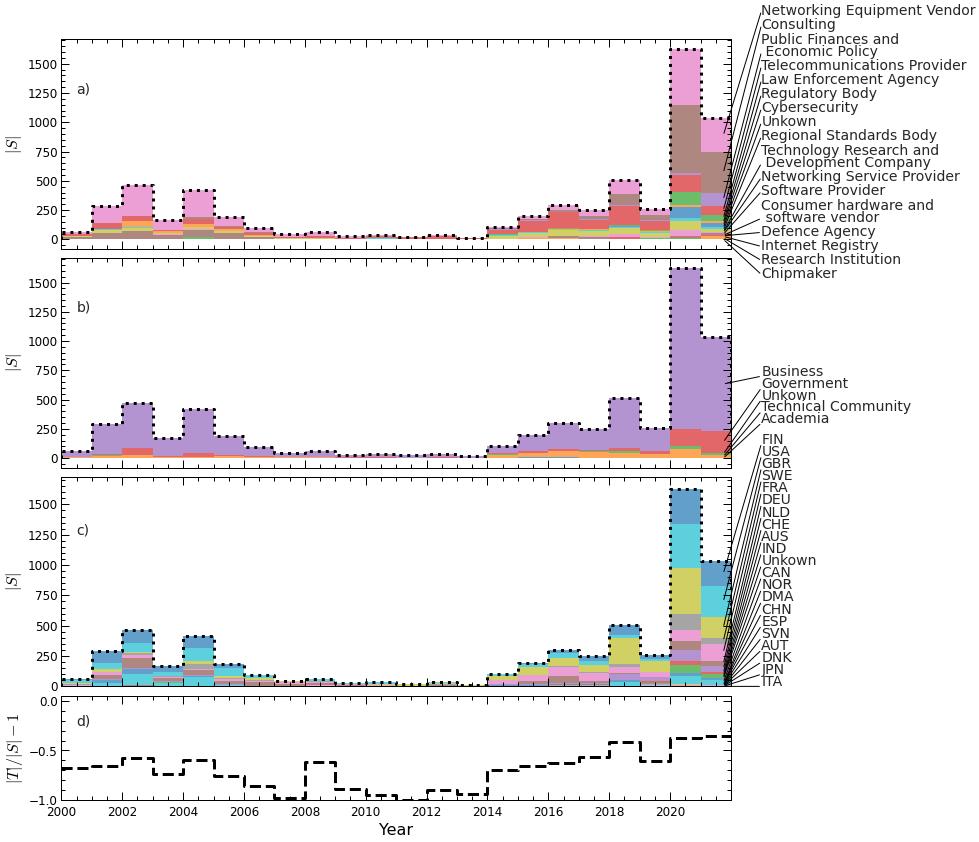

In [29]:
fig, axis = plt.subplots(
    4, 1,
    figsize=(12, 14),
    sharex=True, sharey='row',
    gridspec_kw={'height_ratios': [2, 2, 2, 1]},
    facecolor="w", edgecolor="k",
)
fig.subplots_adjust(
    hspace=0.05,
    wspace=0.0,
)

years = np.arange(year_of_first_msg, year_of_last_msg+1)
years = [yr for yr in years for i in range(2)]
sset_counts_total = np.zeros(len(np.arange(year_of_first_msg, year_of_last_msg+1)) * 2)
first = True
for cat, dic in results_cat.items():
    # doublicate everything
    counts = [0] + [c for c in list(dic.values()) for i in range(2)][:-1]
    
    axis[0].fill_between(
        years,
        sset_counts_total,
        sset_counts_total + counts,
        alpha=0.7,
    )
    
    arrow_x1 = np.max(years)
    arrow_x2 = np.max(years)+1
    
    arrow_y1 = [sset_counts_total[idx] + counts[idx]/2 for idx, year in enumerate(years) if year == arrow_x1][0]
    if first:
        arrow_y2 = -300
        first = False
    else:
        arrow_y2 = arrow_y2 + 120
    
    axis[0].annotate(
        '',
        xy=(arrow_x1-0.25, arrow_y1), xycoords='data',
        xytext=(arrow_x2, arrow_y2), textcoords='data',
        arrowprops=dict(arrowstyle="-", connectionstyle="arc3"),
    )
    
    if '\n' in cat:
        axis[0].text(arrow_x2, arrow_y2-30, f"{cat}", linespacing=0.8)
        arrow_y2 = arrow_y2 + 110
    else:
        axis[0].text(arrow_x2, arrow_y2-30, f"{cat}")
        
    #axis[0].text(arrow_x2, arrow_y2, f"{cat}; {np.sum(counts)}",)
    sset_counts_total += counts

sset_counts_total = np.zeros(len(np.arange(year_of_first_msg, year_of_last_msg+1)) * 2)
first = True
for shgr, dic in results_shgr.items():
    # doublicate everything
    counts = [0] + [c for c in list(dic.values()) for i in range(2)][:-1]
    
    axis[1].fill_between(
        years,
        sset_counts_total,
        sset_counts_total + counts,
        alpha=0.7,
    )
    
    arrow_x1 = np.max(years)
    arrow_x2 = np.max(years)+1
    
    arrow_y1 = [sset_counts_total[idx] + counts[idx]/2 for idx, year in enumerate(years) if year == arrow_x1][0]
    if first:
        arrow_y2 = arrow_y1 + 300
        first = False
    else:
        arrow_y2 = arrow_y2 + 100
    
    axis[1].text(arrow_x2, arrow_y2, f"{shgr}",)
    #axis[1].text(arrow_x2, arrow_y2, f"{shgr}; {np.sum(counts)}",)
    axis[1].annotate(
        '',
        xy=(arrow_x1-0.25, arrow_y1), xycoords='data',
        xytext=(arrow_x2, arrow_y2), textcoords='data',
        arrowprops=dict(arrowstyle="-", connectionstyle="arc3"),
    )
    sset_counts_total += counts

sset_counts_total = np.zeros(len(np.arange(year_of_first_msg, year_of_last_msg+1)) * 2)
first = True
for nation, dic in results_nat.items():
    # doublicate everything
    counts = [0] + [c for c in list(dic.values()) for i in range(2)][:-1]
    
    axis[2].fill_between(
        years,
        sset_counts_total,
        sset_counts_total + counts,
        alpha=0.7,
    )
    
    arrow_x1 = np.max(years)
    arrow_x2 = np.max(years)+1
    
    arrow_y1 = [sset_counts_total[idx] + counts[idx]/2 for idx, year in enumerate(years) if year == arrow_x1][0]
    if first:
        arrow_y2 = arrow_y1
        first = False
    else:
        arrow_y2 = arrow_y2 + 100
    
    axis[2].text(arrow_x2, arrow_y2, f"{nation}",)
    #axis[2].text(arrow_x2, arrow_y2, f"{nation}; {np.sum(counts)}",)
    axis[2].annotate(
        '',
        xy=(arrow_x1-0.25, arrow_y1), xycoords='data',
        xytext=(arrow_x2, arrow_y2), textcoords='data',
        arrowprops=dict(arrowstyle="-", connectionstyle="arc3"),
    )
    sset_counts_total += counts

axis[3].plot(
    years,
    tset_counts_total / sset_counts_total - 1,
    linewidth=3,
    linestyle='--',
    color='k',
    drawstyle='steps',
)
# axis[3].hlines(
#     y=0,
#     xmin=year_of_first_msg,
#     xmax=year_of_last_msg,
#     linewidth=3,
#     linestyle='-',
#     color='k',
# )

for idx in range(len(axis)-1):
    axis[idx].plot(
        years,
        sset_counts_total,
        linewidth=3,
        linestyle=':',
        color='k',
        drawstyle='steps',
    )
    axis[idx].set_ylabel(r'$|S|$')

    
for idx in range(len(axis)):
    axis[idx].set_xlim(year_of_first_msg, year_of_last_msg)

panel_label = {"a": 1250, "b": 1250, "c": 1250, "d": -0.25}
for idx, (lab, ypos) in enumerate(panel_label.items()):
    axis[idx].text(2000.5, ypos, f"{lab})")
    
axis[2].set_ylim(0, np.max(sset_counts_total)+100)
axis[0].legend(
    loc=2,
    edgecolor='white',
    facecolor='white',
    framealpha=0.7,
    #ncol=3,
)

axis[3].set_xticks(np.arange(2000, 2022, 2))
axis[3].set_xlabel('Year')
axis[3].set_ylabel(r'$|T| / |S| - 1$')
axis[3].set_ylim(-1., 0.05)

#"""
plt.savefig(
    f"{mlist_name}_sset_hist_msgs.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""

In [22]:
np.max(tset_counts_total[1:] / sset_counts_total[1:] - 1)

-0.2657004830917874

In [23]:
tset_counts_total[1:] / sset_counts_total[1:] - 1

array([-0.67213115, -0.67213115, -0.65051903, -0.65051903, -0.57905983,
       -0.57905983, -0.73372781, -0.73372781, -0.59808612, -0.59808612,
       -0.75132275, -0.75132275, -0.85106383, -0.85106383, -0.97826087,
       -0.97826087, -0.61666667, -0.61666667, -0.88888889, -0.88888889,
       -0.94285714, -0.94285714, -1.        , -1.        , -0.89473684,
       -0.89473684, -0.93333333, -0.93333333, -0.69902913, -0.69902913,
       -0.65989848, -0.65989848, -0.62962963, -0.62962963, -0.56451613,
       -0.56451613, -0.41568627, -0.41568627, -0.60617761, -0.60617761,
       -0.37676706, -0.37676706, -0.35299807, -0.35299807, -0.26570048])

In [24]:
cat_sum = {}
for key, value in results_cat.items():
    cat_sum[key] = np.sum(list(value.values()))
    
indices = np.argsort(list(cat_sum.values()))
cat_sum = {list(cat_sum.keys())[idx] : list(cat_sum.values())[idx] for idx in indices}
cat_sum

{'Chipmaker': 2,
 'Consumer hardware and\n software vendor': 3,
 'Technology Research and\n Development Company': 6,
 'Defence Agency': 32,
 'Internet Registry': 48,
 'Research Institution': 55,
 'Unkown': 120,
 'Cybersecurity': 135,
 'Networking Service Provider': 157,
 'Public Finances and\n Economic Policy': 172,
 'Regulatory Body': 176,
 'Law Enforcement Agency': 204,
 'Software Provider': 385,
 'Regional Standards Body': 466,
 'Telecommunications Provider': 1126,
 'Consulting': 1235,
 'Networking Equipment Vendor': 2093}

In [25]:
shgr_sum = {}
for key, value in results_shgr.items():
    shgr_sum[key] = np.sum(list(value.values()))
    
indices = np.argsort(list(shgr_sum.values()))
shgr_sum = {list(shgr_sum.keys())[idx] : list(shgr_sum.values())[idx] for idx in indices}
shgr_sum

{'Academia': 24,
 'Unkown': 106,
 'Technical Community': 468,
 'Government': 603,
 'Business': 5214}

In [26]:
nations_sum = {}
for key, value in results_nat.items():
    nations_sum[key] = np.sum(list(value.values()))
    
indices = np.argsort(list(nations_sum.values()))
nations_sum = {list(nations_sum.keys())[idx] : list(nations_sum.values())[idx] for idx in indices}
nations_sum

{'DNK': 1,
 'SVN': 1,
 'DMA': 1,
 'JPN': 4,
 'ITA': 6,
 'AUT': 6,
 'IND': 7,
 'NOR': 14,
 'CHN': 22,
 'ESP': 50,
 'CHE': 89,
 'AUS': 114,
 'Unkown': 156,
 'NLD': 294,
 'SWE': 320,
 'CAN': 402,
 'DEU': 536,
 'FRA': 713,
 'FIN': 1184,
 'USA': 1214,
 'GBR': 1281}